# **Topic Modeling with Llama2** 🦙


We will explore how we can use Llama2 for Topic Modeling without the need to pass every single document to the model. Instead, we are going to leverage BERTopic, a modular topic modeling technique that can use any LLM for fine-tuning topic representations.

BERTopic works rather straightforward. It consists of 5 sequential steps: embedding documents, reducing embeddings in dimensionality, cluster embeddings, tokenize documents per cluster, and finally extract the best representing words per topic.
<br>
<div>
<img src="https://github.com/MaartenGr/BERTopic/assets/25746895/e9b0d8cf-2e19-4bf1-beb4-4ff2d9fa5e2d" width="500"/>
</div>

However, with the rise of LLMs like **Llama 2**, we can do much better than a bunch of independent words per topic. It is computally not feasible to pass all documents to Llama 2 directly and have it analyze them. We can employ vector databases for search but we are not entirely search which topics to search for.

Instead, we will leverage the clusters and topics that were created by BERTopic and have Llama 2 fine-tune and distill that information into something more accurate.

This is the best of both worlds, the topic creation of BERTopic together with the topic representation of Llama 2.
<br>
<div>
<img src="https://github.com/MaartenGr/BERTopic/assets/25746895/7c7374a1-5b41-4e93-aafd-a1587367767b" width="500"/>
</div>



We will start by installing a number of packages that we are going to use :

In [ ]:
%%capture
!pip install bertopic accelerate bitsandbytes xformers adjustText

In [ ]:
!pip install langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=1635f5f14da0081f06970b77c43ec26cfa332a3526cf515d7fce2d5750b49c79
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


# 📄 **Data**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import pandas as pd

# Charger le JSON
with open("/content/drive/MyDrive/hal_morocco_clean.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Créer un DataFrame pour plus de facilité
df = pd.DataFrame(data)

# Vérifier que les champs existent
print("Colonnes disponibles :", df.columns.tolist())

# Créer un champ combiné title + abstract
df['document'] = df['title_clean'].fillna('') + ". " + df['abstract_clean'].fillna('')

# Vérifier les valeurs nulles
print("Valeurs nulles par colonne :")
print(df[['title_clean', 'abstract_clean', 'document']].isnull().sum())

# Nombre total de documents
print("Nombre total de documents :", len(df))

# Afficher 5 documents aléatoires
df[['title_clean', 'abstract_clean', 'document']].sample(5)


Colonnes disponibles : ['docid', 'label_s', 'title_s', 'abstract_s', 'authFullName_s', 'labStructName_s', 'labStructCountry_s', 'structName_s', 'structCountry_s', 'instStructName_s', 'instStructCountry_s', 'halId_s', 'submittedDate_tdate', 'authOrganism_s', 'title_clean', 'abstract_clean', 'corpus', 'corpus_length', 'country_detected', 'year']
Valeurs nulles par colonne :
title_clean       0
abstract_clean    0
document          0
dtype: int64
Nombre total de documents : 19014


,title_clean,abstract_clean,document
2129,La valeur ajoutée de la formation continue en ...,Dans ce papier nous nous intéressons à mettre ...,La valeur ajoutée de la formation continue en ...
17180,"PHÉNOMÈNES STOCHASTIQUES, RÉPONSE LINÉAIRE, DI...",Ce cours avancé qui s’adresse aux étudiants de...,"PHÉNOMÈNES STOCHASTIQUES, RÉPONSE LINÉAIRE, DI..."
11306,La gouvernance des Technologies de l'Informati...,"Pendant les dernières années, les Technologies...",La gouvernance des Technologies de l'Informati...
2616,On the well-posedness of the unsteady Velocity...,In this paper we study the three-dimensional v...,On the well-posedness of the unsteady Velocity...
8611,Evaluation of global energy performance of bui...,Passive latent heat thermal energy storage tec...,Evaluation of global energy performance of bui...


In [ ]:
import re

def clean_text_keep_punct(text):
    # Mettre en minuscules
    text = text.lower()
    # Supprimer les retours à la ligne
    text = text.replace("\n", " ")
    # Supprimer les espaces multiples
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Appliquer le nettoyage
df['document_clean'] = df['document'].apply(clean_text_keep_punct)

# Inspecter quelques exemples
df[['document', 'document_clean']].sample(5)


,document,document_clean
17106,Combined Continuous Resin Adsorption and Anaer...,combined continuous resin adsorption and anaer...
9959,L’évolution du végétal en ville à Marrakech. A...,l’évolution du végétal en ville à marrakech. a...
11588,Novel Soil Impact Prediction Model on Bandwidt...,novel soil impact prediction model on bandwidt...
3225,Spin and Orbital Magnetisms of NiFe Compound: ...,spin and orbital magnetisms of nife compound: ...
10985,Intelligent System Based on GAN Model for Deci...,intelligent system based on gan model for deci...


In [ ]:
import nltk
from nltk.corpus import stopwords

# Télécharger les stopwords si pas déjà fait
nltk.download('stopwords')

# Créer une liste combinée de stopwords français et anglais
stop_words_en = set(stopwords.words('english'))
stop_words_fr = set(stopwords.words('french'))
all_stopwords = stop_words_en.union(stop_words_fr)

def remove_stopwords(text):
    words = text.split()
    filtered = [w for w in words if w not in all_stopwords]
    return " ".join(filtered)

# Appliquer la suppression sur le champ combiné titre+abstract
df['document_nostop'] = df['document_clean'].apply(remove_stopwords)

# Inspecter quelques exemples
df[['document_clean', 'document_nostop']].sample(5)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,document_clean,document_nostop
8419,"du ""maroc inutile"" au maroc en déclin. la décr...","""maroc inutile"" maroc déclin. décroissance ter..."
278,courbes algébriques et surfaces de riemann. ce...,courbes algébriques surfaces riemann. papier c...
5615,quantive detection of avipoxvirus dna in houba...,quantive detection avipoxvirus dna houbara bus...
12630,ultrasonic field in a nonlinear medium in the ...,ultrasonic field nonlinear medium case uniform...
6190,a multiresolution method for fitting scattered...,multiresolution method fitting scattered data ...


In [ ]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

DetectorFactory.seed = 42  # pour la reproductibilité


In [ ]:
def detect_language_safe(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"


In [ ]:
df["lang"] = df["document_nostop"].apply(detect_language_safe)


In [ ]:
df["lang"].value_counts()


,count
lang,
en,13616
fr,4943
it,174
ca,64
ro,56
es,54
ar,26
id,12
pt,11


In [ ]:
df[["document_clean", "lang"]].sample(10)


,document_clean,lang
16070,left main coronary artery lesion: surgical rev...,en
3814,agroforestry for fruit trees in europe and med...,en
10474,no-reference mesh visual quality assessment us...,en
4460,la finance islamique dans les marchés financie...,fr
11997,« villes moyennes et labellisation : quels eff...,fr
5699,continental late pliocene paleoclimatic histor...,en
11043,sushi for a bingham flow type problem.,en
17209,development of optimal conditions for the germ...,en
3344,les facteurs de l’échec entrepreneurial des pm...,fr
11115,improvement of inverted planar heterojunction ...,en


In [ ]:
df_en = df[df['lang'] == 'en'].copy()
text_for_model = df_en['document_nostop'].tolist()
print(f"Nombre de documents anglais : {len(text_for_model)}")


Nombre de documents anglais : 13616


In [ ]:
df.shape
df.columns
df.head(5)


,docid,label_s,title_s,abstract_s,authFullName_s,labStructName_s,labStructCountry_s,structName_s,structCountry_s,instStructName_s,...,title_clean,abstract_clean,corpus,corpus_length,country_detected,year,document,document_clean,document_nostop,lang
0,1000501,"Ndeye Fatou N. F. Ngom, Patricia P. Garnier, O...",[Extraction of three-dimensional soil pore spa...,[This paper presents a geometrical model of so...,"[Ndeye Fatou N. F. Ngom, Patricia P. Garnier, ...",[Unité de modélisation mathématique et informa...,"[fr, fr, de]",[Unité de modélisation mathématique et informa...,"[fr, sn, fr, fr, cm, fr, ma, sn, fr, fr, fr, d...",[Université Gaston Berger de Saint-Louis Sénég...,...,Extraction of three-dimensional soil pore spac...,This paper presents a geometrical model of soi...,Extraction of three-dimensional soil pore spac...,1663,ma,2014,Extraction of three-dimensional soil pore spac...,extraction of three-dimensional soil pore spac...,extraction three-dimensional soil pore space m...,en
1,1000575,"Ndèye Fatou N. F. Ngom, Olivier O. Monga, Moha...",[3D shape extraction segmentation and represen...,[This paper focuses on the modeling of soil mi...,"[Ndèye Fatou N. F. Ngom, Olivier O. Monga, Moh...",[Unité de modélisation mathématique et informa...,"[fr, fr]",[Unité de modélisation mathématique et informa...,"[fr, sn, fr, fr, cm, fr, ma, sn, fr, fr, fr]",[Université Gaston Berger de Saint-Louis Sénég...,...,3D shape extraction segmentation and represent...,This paper focuses on the modeling of soil mic...,3D shape extraction segmentation and represent...,1860,ma,2014,3D shape extraction segmentation and represent...,3d shape extraction segmentation and represent...,3d shape extraction segmentation representatio...,en
2,1001128,"Kacem K. Rharrabe, Fouad F. Sayah, Frederic F....",[Gustatory perception of phytoecdysteroids in ...,[Phytoecdysteroids are steroidal compounds pro...,"[Kacem K. Rharrabe, Fouad F. Sayah, Frederic F...",[Physiologie de l'Insecte : Signalisation et C...,[fr],[Physiologie de l'Insecte : Signalisation et C...,"[fr, fr, fr, fr, ma, ma]",[Institut National de la Recherche Agronomique...,...,Gustatory perception of phytoecdysteroids in P...,Phytoecdysteroids are steroidal compounds prod...,Gustatory perception of phytoecdysteroids in P...,1483,ma,2014,Gustatory perception of phytoecdysteroids in P...,gustatory perception of phytoecdysteroids in p...,gustatory perception phytoecdysteroids plodia ...,en
3,1001543,"Aurelie A. Cotillard, Sean S. Kennedy, Ling Ch...",[Dietary intervention impact on gut microbial ...,[Complex gene-environment interactions are con...,"[Aurelie A. Cotillard, Sean S. Kennedy, Ling C...","[Centre de Recherche des Cordeliers, MetaGenoP...","[fr, fr, fr, fr]","[U872 Centre de Recherche des Cordeliers, Nutr...","[fr, fr, fr, fr, fr, fr, fr, fr, fr, fr, fr, f...","[Université Pierre et Marie Curie - Paris 6, U...",...,Dietary intervention impact on gut microbial g...,Complex gene-environment interactions are cons...,Dietary intervention impact on gut microbial g...,1466,ma,2014,Dietary intervention impact on gut microbial g...,dietary intervention impact on gut microbial g...,dietary intervention impact gut microbial gene...,en
4,1002495,"Bernard Delcaillau, E. Laville, M. Amhrar, M. ...",[Quaternary evolution of the Marrakech High At...,"[Here, we consider the Ourika and Rheraia drai...","[Bernard Delcaillau, E. Laville, M. Amhrar, M....",[Morphodynamique Continentale et Côtière],[fr],"[Morphodynamique Continentale et Côtière, Univ...","[fr, fr, fr, fr, fr, fr, fr, ma, ma]","[Université de Caen Normandie, Institut nation...",...,Quaternary evolution of the Marrakech High Atl...,"Here, we consider the Ourika and Rheraia drain...",Quaternary evolution of the Marrakech High Atl...,1648,ma,2014,Quaternary evolution of the Marrakech High Atl...,quaternary evolution of the marrakech high atl...,quaternary evolution marrakech high atlas morp...,en


# 🤗 HuggingFace Hub Credentials


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# 🦙 **Llama 2**


We will be focusing on the `'meta-llama/Llama-2-7b-chat-hf'` variant. It is large enough to give interesting and useful results whilst small enough that it can be run on our environment.



In [ ]:
from torch import cuda

model_id = 'meta-llama/Llama-2-7b-chat-hf'
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

print(device)

cuda:0


## **Optimization & Quantization**

In order to load our 13 billion parameter model, we will need to perform some optimization tricks. Since we have limited VRAM and not an A100 GPU, we will need to "condense" the model a bit so that we can run it.

There are a number of tricks that we can use but the main principle is going to be 4-bit quantization.



In [ ]:
from torch import bfloat16
import transformers

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type='nf4',  # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16  # Computation type
)

In [ ]:
print("CUDA available:", cuda.is_available())
print("GPU name:", cuda.get_device_name(0))


CUDA available: True
GPU name: Tesla T4


These four parameters that we just run are incredibly important and bring many LLM applications to consumers:
* `load_in_4bit`
  * Allows us to load the model in 4-bit precision compared to the original 32-bit precision
  * This gives us an incredibly speed up and reduces memory!
* `bnb_4bit_quant_type`
  * This is the type of 4-bit precision. The paper recommends normalized float 4-bit, so that is what we are going to use!
* `bnb_4bit_use_double_quant`
  * This is a neat trick as it perform a second quantization after the first which further reduces the necessary bits
* `bnb_4bit_compute_dtype`
  * The compute type used during computation, which further speeds up the model.



Using this configuration, we can start loading in the model as well as the tokenizer:

In [ ]:
# Llama 2 Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

# Llama 2 Model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',
)
model.eval()

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMS

Using the model and tokenizer, we will generate a HuggingFace transformers pipeline that allows us to easily generate new text:

In [ ]:
# Our text generator
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)

Device set to use cuda:0


In [ ]:
prompt = f"""
You are a scientific research assistant.

Given the following paper title and abstract, identify the main research topic in one short sentence.

Text:
{text_for_model[0]}
"""

output = generator(prompt)
print(output[0]["generated_text"])



You are a scientific research assistant.

Given the following paper title and abstract, identify the main research topic in one short sentence.

Text:
extraction three-dimensional soil pore space microtomography images using geometrical approach. paper presents geometrical model soil pore space based quantitative analysis synchrotron x-ray microtomography data. model calculated minimal set balls recovered skeleton pore space using delaunay tessellation, simply connected sets balls could considered potential pore channels. model (dtm software) applied three-dimensional tomography reconstructions soil aggregates (~5 mm diameter) two management systems (conventionally tilled soil, namely ctt grassland soil, namely gl) voxel edge length 3.2 μm 5.4 μm, respectively. geometric characteristics frequency distribution pore radius, length, tortuosity well retention curve calculated using model. organic matter decomposition also simulated using dtm approach. results compared pore space statistic

## **Prompt Engineering**



Although we can directly prompt the model, there is actually a template that we need to follow. The template looks as follows:

```python
"""
<s>[INST] <<SYS>>

{{ System Prompt }}

<</SYS>>

{{ User Prompt }} [/INST]

{{ Model Answer }}
"""
```

This template consists of two main components, namely the `{{ System Prompt }}` and the `{{ User Prompt }}`:
* The `{{ System Prompt }}` helps us guide the model during a conversation. For example, we can say that it is a helpful assisant that is specialized in labeling topics.
* The  `{{ User Prompt }}` is where we ask it a question.

 `[INST]` tags, these are used to identify the beginning and end of a prompt.



### **Prompt Template**

We are going to keep our `system prompt` simple and to the point:

In [ ]:
# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics.
<</SYS>>
"""

We will tell the model that it is simply a helpful assistant for labeling topics since that is our main goal.

In contrast, our `user prompt` is going to the be a bit more involved. It will consist of two components, an **example** and the **main prompt**.

Let's start with the **example**. Most LLMs do a much better job of generating
accurate responses if you give them an example to work with.




In [ ]:
# Example prompt demonstrating the output we are looking for
example_prompt = """
I have a topic that contains the following documents:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the word food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.

[/INST] Environmental impacts of eating meat
"""



Next, we will create a template that we can use within BERTopic:

In [ ]:
# Our main prompt with documents ([DOCUMENTS]) and keywords ([KEYWORDS]) tags
main_prompt = """
[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
[/INST]
"""

There are two BERTopic-specific tags that are of interest, namely `[DOCUMENTS]` and `[KEYWORDS]`:

* `[DOCUMENTS]` contain the top 5 most relevant documents to the topic
* `[KEYWORDS]` contain the top 10 most relevant keywords to the topic as generated through c-TF-IDF

This template will be filled accordingly to each topic. And finally, we can combine this into our final prompt:

In [ ]:
prompt = system_prompt + example_prompt + main_prompt

# 🗨️ **BERTopic**

Before we can start with topic modeling, we will first need to perform two steps:
* Pre-calculating Embeddings
* Defining Sub-models

## **Preparing Embeddings**

By pre-calculating the embeddings for each document, we can speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters if needed.



In [ ]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en")
# embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

embeddings = embedding_model.encode(
    text_for_model,
    show_progress_bar=True
)


Batches:   0%|          | 0/426 [00:00<?, ?it/s]

## **Sub-models**

Next, we will define all sub-models in BERTopic and do some small tweaks to the number of clusters to be created, setting random states, etc.

In [ ]:
from umap import UMAP
from hdbscan import HDBSCAN


umap_model=UMAP(
    n_neighbors=25,
    n_components=5,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)
hdbscan_model=HDBSCAN(
    min_cluster_size=40,
    min_samples=10,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)



As a small bonus, we are going to reduce the embeddings we created before to 2-dimensions so that we can use them for visualization purposes when we have created our topics.

In [ ]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### **Representation Models**

One of the ways we are going to represent the topics is with Llama 2 which should give us a nice label. However, we might want to have additional representations to view a topic from multiple angles.

Here, we will be using c-TF-IDF as our main representation and [KeyBERT](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#keybertinspired), [MMR](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#maximalmarginalrelevance), and [Llama 2](https://maartengr.github.io/BERTopic/getting_started/representation/llm.html) as our additional representations.

In [ ]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

# Text generation with Llama 2
llama2 = TextGeneration(generator, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    "Llama2": llama2,
    "MMR": mmr,
}

# 🔥 **Training**

Now that we have our models prepared, we can start training our topic model! We supply BERTopic with the sub-models of interest, run `.fit_transform`, and see what kind of topics we get.

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(text_for_model, embeddings)

2025-12-15 17:26:26,682 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-15 17:26:50,188 - BERTopic - Dimensionality - Completed ✓
2025-12-15 17:26:50,189 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-15 17:26:50,680 - BERTopic - Cluster - Completed ✓
2025-12-15 17:26:50,693 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 60/60 [09:51<00:00,  9.85s/it]
2025-12-15 17:36:50,463 - BERTopic - Representation - Completed ✓


Now that we are done training our model, let's see what topics were generated:

In [ ]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,Llama2,MMR,Representative_Docs
0,-1,5211,-1_data_using_based_model,"[data, using, based, model, study, results, wa...","[research, impact, environmental, models, mode...",[Data-Driven Models for Sustainable Agricultur...,"[data, results, water, analysis, soil, morocco...",[data driven forecasting models urban air poll...
1,0,1699,0_patients_case_report_patient,"[patients, case, report, patient, disease, cli...","[cardiac, coronary, ventricular, patients, pat...","[Cardiac Infections, , , , , , , , , ]","[patients, patient, disease, clinical, diagnos...",[acute myocarditis covid-19 infection young pa...
2,1,365,1_based_abstract_networks_learning,"[based, abstract, networks, learning, multi, a...","[convolutional, visual, mesh, modeling, salien...","[Blind Mesh Quality Assessment, , , , , , , , , ]","[abstract, networks, learning, blind, chain, a...",[no-reference mesh visual quality assessment u...
3,2,357,2_adsorption_removal_catalyst_photocatalytic,"[adsorption, removal, catalyst, photocatalytic...","[photocatalytic, photocatalyst, tio2, adsorpti...",[Removal of Toxic Dyes from Water Using Advanc...,"[adsorption, photocatalytic, catalysts, chitos...",[sunlight driven photocatalytic degradation rh...
4,3,347,3_financial_research_performance_digital,"[financial, research, performance, digital, pu...","[csr, sustainability, article, research, impac...",[Digital Transformation and CSR: A Moroccan St...,"[financial, research, digital, organizational,...",[eco-strategy: towards new generation manageri...
5,4,332,4_image_images_classification_3d,"[image, images, classification, 3d, based, pro...","[segmentation, descriptors, clustering, convol...","[Image Segmentation and Classification, , , , ...","[images, classification, 3d, segmentation, tex...",[extracting masks herbarium specimen images ba...
6,5,249,5_networks_wireless_network_channel,"[networks, wireless, network, channel, sensor,...","[networks, throughput, sensors, network, sensi...","[Wireless Sensor Networks, , , , , , , , , ]","[networks, wireless, nodes, mimo, signal, mult...",[optimal power allocation maximizing network l...
7,6,200,6_atlas_rocks_ma_magmatic,"[atlas, rocks, ma, magmatic, tectonic, late, o...","[neoproterozoic, magmatism, miocene, zircon, o...",[Tectonic evolution of the Atlas Mountains and...,"[atlas, rocks, ma, magmatic, tectonic, massif,...",[neoproterozoic granitoids basement moroccan c...
8,7,192,7_genetic_olive_germination_varieties,"[genetic, olive, germination, varieties, flowe...","[genotypes, cultivars, cultivar, germplasm, ol...","[Olive Genetics and Breeding, , , , , , , , , ]","[genetic, olive, germination, varieties, genot...",[characterization olive population relevant ge...
9,8,189,8_control_power_pv_dc,"[control, power, pv, dc, controller, system, e...","[microgrids, renewable, microgrid, photovoltai...",[Control and Power Management in Renewable Ene...,"[control, power, pv, photovoltaic, fuzzy, moto...",[experimental evaluation advanced predictive c...


In [ ]:
topic_model.get_topic(1, full=True)["KeyBERT"]

[('convolutional', np.float32(0.9057803)),
 ('visual', np.float32(0.89012814)),
 ('mesh', np.float32(0.88667953)),
 ('modeling', np.float32(0.8812907)),
 ('saliency', np.float32(0.87868917)),
 ('models', np.float32(0.876595)),
 ('3d', np.float32(0.876176)),
 ('modelling', np.float32(0.8698937)),
 ('model', np.float32(0.8643465)),
 ('neural', np.float32(0.86076057))]

In [ ]:
topic_model.get_topic(1, full=True)



```
# This is formatted as code
```

We got 59 topics that were created .We can use the labels by Llama 2 and assign them to topics that we have created. Normally, the default topic representation would be c-TF-IDF, but we will focus on Llama 2 representations instead.


In [ ]:

llama2_labels = {}

for topic_id, reps in topic_model.get_topics(full=True)["Llama2"].items():
    if reps:
        llama2_labels[topic_id] = reps[0][0].split("\n")[0]
    else:
        llama2_labels[topic_id] = "Other"


topic_model.set_topic_labels(llama2_labels)

# 📊 **Visualize**
We can go through each topic manually, which would take a lot of work, or we can visualize them all in a single interactive graph.
BERTopic has a bunch of [visualization functions](https://medium.com/r/?url=https%3A%2F%2Fmaartengr.github.io%2FBERTopic%2Fgetting_started%2Fvisualization%2Fvisualize_documents.html) that we can use. For now, we are sticking with visualizing the documents.

In [ ]:
topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)

# 🖼️ (BONUS): **Advanced Visualization**

Although we can use the built-in visualization features of BERTopic, we can also create a static visualization that might be a bit more informative.

We start by creating the necessary variables that contain our reduced embeddings and representations:

In [ ]:
import itertools
import pandas as pd

# Define colors for the visualization to iterate over
colors = itertools.cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'])
color_key = {str(topic): next(colors) for topic in set(topic_model.topics_) if topic != -1}

# Prepare dataframe and ignore outliers
df = pd.DataFrame({"x": reduced_embeddings[:, 0], "y": reduced_embeddings[:, 1], "Topic": [str(t) for t in topic_model.topics_]})
df["Length"] = [len(doc) for doc in text_for_model]
df = df.loc[df.Topic != "-1"]
df = df.loc[(df.y > -10) & (df.y < 10) & (df.x < 10) & (df.x > -10), :]
df["Topic"] = df["Topic"].astype("category")

# Get centroids of clusters
mean_df = df.groupby("Topic").mean().reset_index()
mean_df.Topic = mean_df.Topic.astype(int)
mean_df = mean_df.sort_values("Topic")

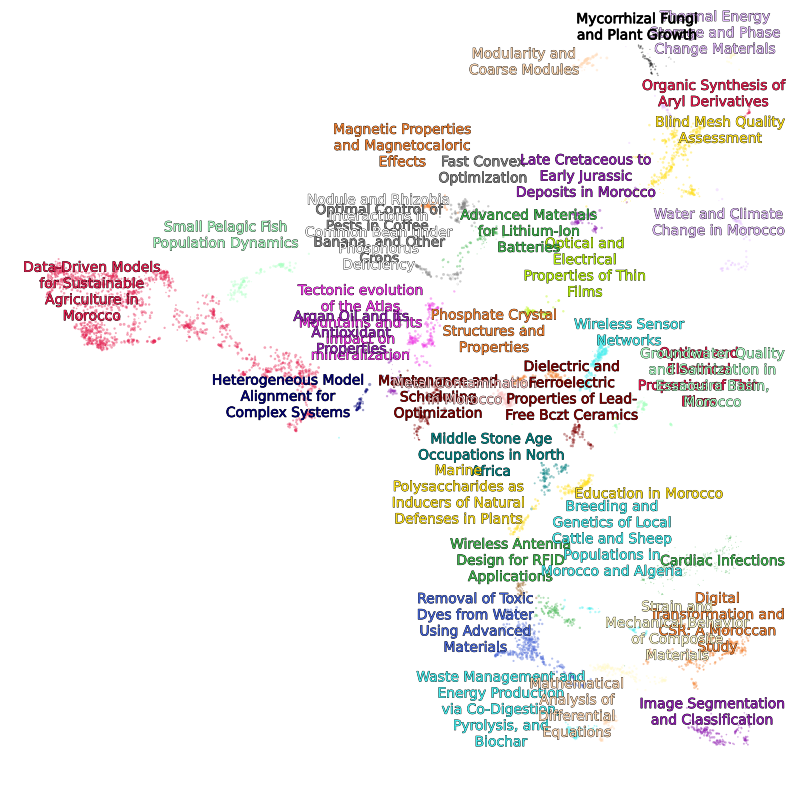

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as pe
import textwrap

fig = plt.figure(figsize=(10, 10))
# sns.scatterplot(data=df, x='x', y='y', c=df['Topic'].map(color_key), alpha=0.4, sizes=(0.4, 10), size="Length")

sns.scatterplot(
    data=df,
    x='x',
    y='y',
    hue='Topic',                     # colorer par Topic
    palette=color_key,               # dictionnaire Topic -> couleur
    alpha=0.4,
    size="Length",                   # taille selon Length
    sizes=(0.4, 10)
)


# Annotate top 50 topics
texts, xs, ys = [], [], []
for row in mean_df.iterrows():
  topic = row[1]["Topic"]
  name = textwrap.fill(topic_model.custom_labels_[int(topic)], 20)

  if int(topic) <= 50:
    xs.append(row[1]["x"])
    ys.append(row[1]["y"])
    texts.append(plt.text(row[1]["x"], row[1]["y"], name, size=10, ha="center", color=color_key[str(int(topic))],
                          path_effects=[pe.withStroke(linewidth=0.5, foreground="black")]
                          ))

# Adjust annotations such that they do not overlap
adjust_text(texts, x=xs, y=ys, time_lim=1, force_text=(0.01, 0.02), force_static=(0.01, 0.02), force_pull=(0.5, 0.5))
plt.axis('off')
plt.legend('', frameon=False)
plt.show()

# Backup Saving

In [ ]:
# To save: model, reduced embeddings, representative docs
!pip install safetensors

In [ ]:
import pickle

with open('rep_docs.pickle', 'wb') as handle:
    pickle.dump(topic_model.representative_docs_, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('reduced_embeddings.pickle', 'wb') as handle:
    pickle.dump(reduced_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [ ]:
embedding_model = "BAAI/bge-small-en"
topic_model.save("final", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

In [ ]:
!zip -r /content/llama2.zip /content/final

  adding: content/final/ (stored 0%)
  adding: content/final/ctfidf_config.json (deflated 65%)
  adding: content/final/topics.json (deflated 84%)
  adding: content/final/topic_embeddings.safetensors (deflated 7%)
  adding: content/final/ctfidf.safetensors (deflated 47%)
  adding: content/final/config.json (deflated 38%)


In [ ]:
!jupyter nbconvert --to markdown Topic_Modeling_with_Llama2.ipynb

[NbConvertApp] Converting notebook Topic_Modeling_with_Llama2.ipynb to markdown
[NbConvertApp] Support files will be in Topic_Modeling_with_Llama2_files/
[NbConvertApp] Making directory Topic_Modeling_with_Llama2_files
[NbConvertApp] Writing 13754635 bytes to Topic_Modeling_with_Llama2.md
